# 1.3.1 IterativeGaussianization

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.marginal import marginal_fit_transform, marginal_transform


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

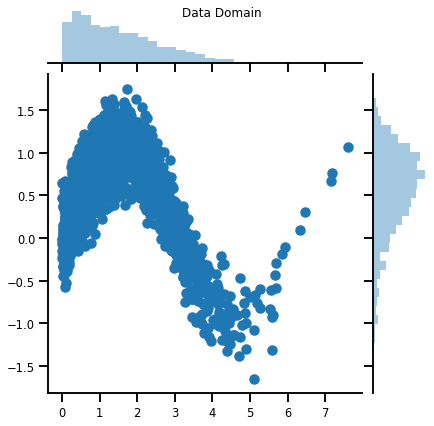

In [3]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1], s=1, color='blue')
plt.suptitle('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [4]:
n_samples = 10_000
data = get_classic(n_samples)

X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Marginal Gaussianization

In [5]:
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.block import InitRBIGBlock


In [6]:
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))


# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# initialize rotation transformation
rot_transform = InitPCARotation()

# initialize marginal gaussianization
eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = InitRBIGBlock(uni_uniformize, rot_transform, eps)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

## Multiple Iterations

##### Helper Function - Default Block Params

In [7]:
%%time

n_layers = 25
params = []
losses = []
ilayer = 0
X_g = X

while ilayer < n_layers:
    
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
        
    # increment
    ilayer += 1
    
    params.append(layer_params)    

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 2.75 s, sys: 17.2 ms, total: 2.77 s
Wall time: 2.75 s


<Figure size 432x288 with 0 Axes>

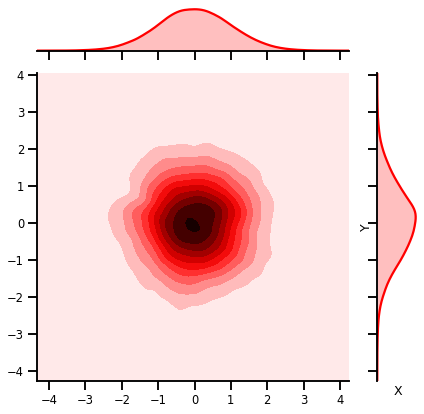

In [8]:
plot_joint(X_g, kind="kde")

## Sampling

In [9]:
from jax import random

key = random.PRNGKey(123)

n_gen_samples = 100_000
n_features = 2


In [10]:
# select the inverse functions
*_, uni_inverse_f = uni_uniformize
*_, igausscdf_inverse_f = InitInverseGaussCDF(eps)
*_, rot_inverse_f = rot_transform

In [11]:
%%time

X_approx = random.normal(key, (10_000, n_features))
for iparam in reversed(params):

    # rotation
    X_approx = rot_inverse_f(iparam, X_approx)
    
    # inverse CDF
    X_approx = igausscdf_inverse_f(iparam, X_approx)
    
    # inverse marginal uniformization with parameters
    X_approx = marginal_transform(X_approx, iparam, uni_inverse_f)
    

CPU times: user 2.6 s, sys: 214 ms, total: 2.81 s
Wall time: 2.33 s


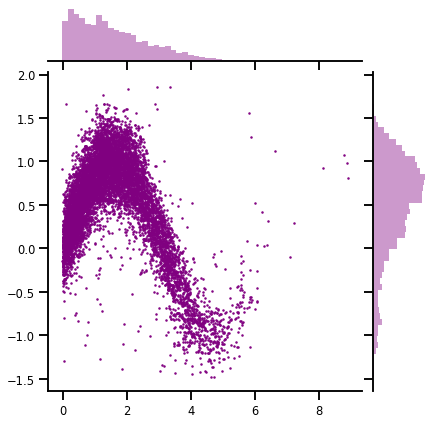

In [12]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=1, color='purple')

## Better Sampling


Recall that the RBIG Block works as follows:


$$
G = \mathbf{R} \Psi
$$

where $\Psi=[\text{CDF}^{-1}\text{U}]^d$. So that means the inverse is:

$$
G^{-1} = \Psi^{-1}\mathbf{R}
$$

where $\Psi^{-1}=[\text{U}^{-1}\text{CDF}]^d$

We're going to add in an extra transformation in the mix. Instead we're going to have: $\Psi^{-1}=\Psi'[\text{U}^{-1}\text{CDF}]^d$
Recall that the RBIG Block works as follows:


$$
G = \mathbf{R} \Psi
$$

where $\Psi=[\text{CDF}^{-1}\text{U}]^d$. So that means the inverse is:

$$
G^{-1} = \Psi^{-1}\mathbf{R}
$$

where $\Psi^{-1}=[\text{U}^{-1}\text{CDF}]^d$

We're going to add in an extra transformation in the mix. Instead we're going to have: $\Psi^{-1}=\Psi'[\text{U}^{-1}\text{CDF}]^d$

In [13]:

igausscdf_fit_transform, *_ = InitInverseGaussCDF(eps)
hist_fit_transform, *_ = uni_uniformize


@jax.jit
def marginal_gaussianization(inputs):
    inputs, _ = marginal_fit_transform(inputs, hist_fit_transform)
    outputs, _ = marginal_fit_transform(inputs, igausscdf_fit_transform)
    return outputs


In [14]:
%%time

X_approx = random.normal(key, (10_000, n_features))
for iparam in reversed(params):
        
    # rotation
    X_approx = rot_inverse_f(iparam, X_approx)
        
    # marginal Gaussianization
    X_approx = marginal_gaussianization(X_approx)
    
    # inverse CDF
    X_approx = igausscdf_inverse_f(iparam, X_approx)
    
    # inverse marginal uniformization with parameters
    X_approx = marginal_transform(X_approx, iparam, uni_inverse_f)
    

    

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 3.94 s, sys: 281 ms, total: 4.22 s
Wall time: 3.56 s


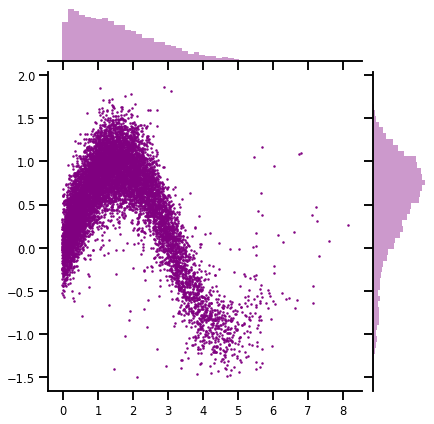

In [15]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=1, color='purple')

## Real Demo

In [16]:
from pathlib import Path

In [17]:
import urllib.request

urls = [
    "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat",
    "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
]
for url in urls:
    
    urllib.request.urlretrieve(url, str(Path(url).name))

In [18]:
from scipy.io import loadmat

file_path = str(Path.cwd().joinpath("Indian_pines_corrected.mat"))
hsi_img = loadmat(file_path)

X = hsi_img['indian_pines_corrected']

print(X.shape)

(145, 145, 200)


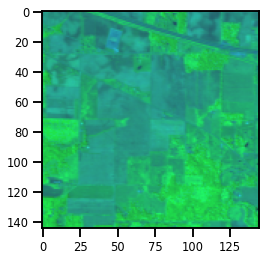

In [19]:
fig, ax = plt.subplots()

rgb_idx =  tuple([..., [110, 40, 12]])
ax.imshow(X[rgb_idx]/X[rgb_idx].max())
plt.show()


In [20]:
# create a long vector
X_vec = X.reshape(-1, X.shape[-1])
# y_vec = y.flatten()[:, np.newaxis]


# scale data
from sklearn.preprocessing import StandardScaler

x_transformer = StandardScaler()

X_vec_s = x_transformer.fit_transform(X_vec)

In [21]:
X = np.array(X_vec_s, dtype=np.float32)


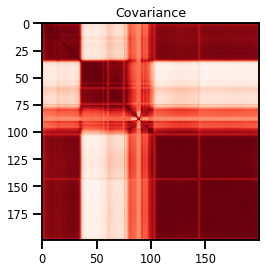

In [22]:
fig, ax = plt.subplots()

ax.imshow(np.cov(X,rowvar=False), cmap='Reds')
ax.set_title("Covariance")
plt.show()

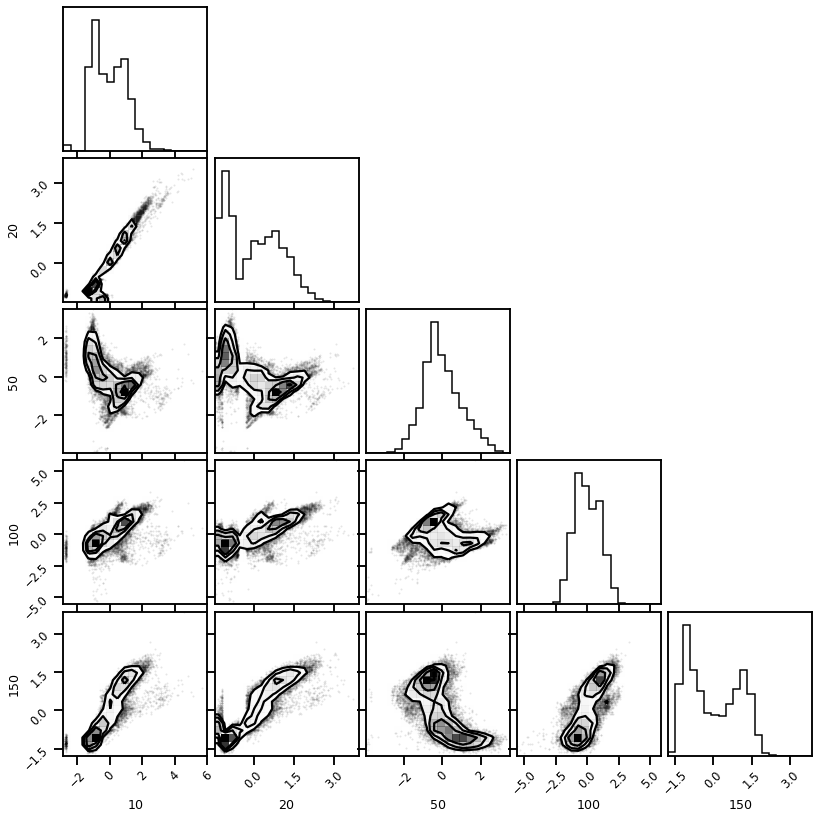

In [23]:
import corner

bands = [10, 20, 50, 100, 150]

figure = corner.corner(
    xs=X[:, bands],
    labels=bands,
    color="black"
)

In [24]:

n_samples, n_features = X.shape
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))


# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=n_samples,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# initialize rotation transformation
rot_transform = InitPCARotation()

# initialize marginal gaussianization
eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = InitRBIGBlock(uni_uniformize, rot_transform, eps)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

#### Training

In [25]:
%%time

n_layers = 50
params = []
losses = []
ilayer = 0
X_g = X

while ilayer < n_layers:
    
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
        
    # increment
    ilayer += 1
    
    params.append(layer_params)    

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 43.1 s, sys: 1min 26s, total: 2min 9s
Wall time: 10.6 s


#### Sampling

In [26]:
%%time

X_samples = random.normal(key, (10_000, n_features))

for iparam in reversed(params):
        
    # rotation
    X_samples = inverse_f_jitted(iparam, X_samples)
    

CPU times: user 1min 20s, sys: 2min 40s, total: 4min 1s
Wall time: 16.4 s


In [27]:
X_samples_cov = np.cov(X_samples, rowvar=False)

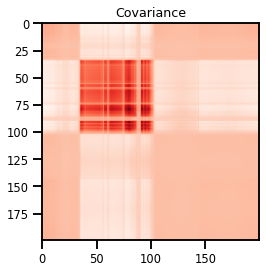

In [28]:
fig, ax = plt.subplots()

ax.imshow(np.cov(X_samples_cov,rowvar=False), cmap='Reds')
ax.set_title("Covariance")
plt.show()

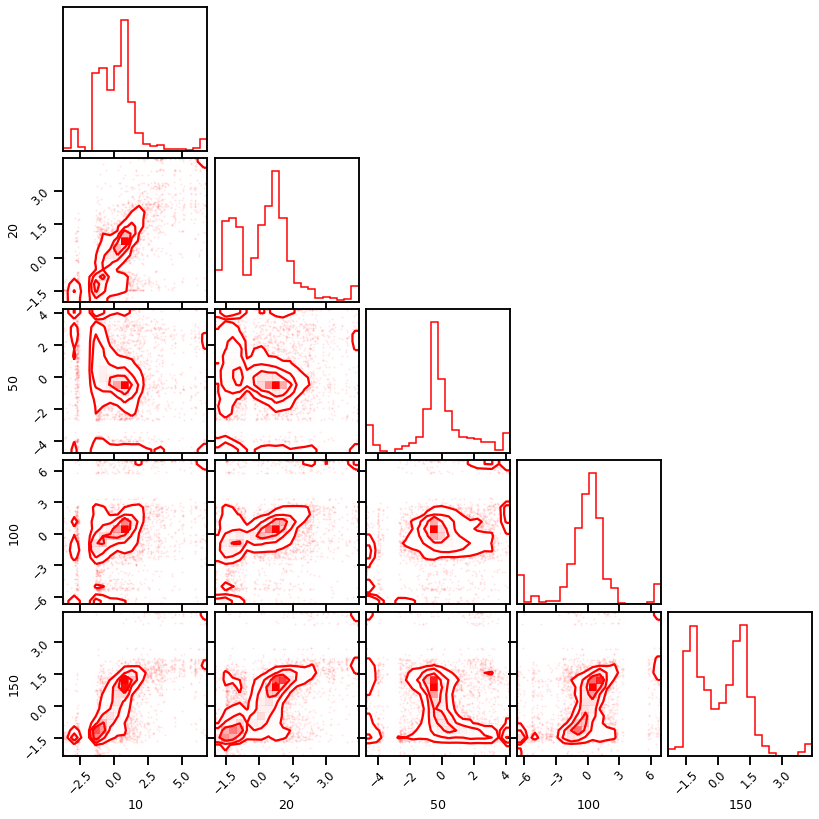

In [29]:
import corner

bands = [10, 20, 50, 100, 150]

figure = corner.corner(
    xs=X_samples[:, bands],
    labels=bands,
    color="red"
)

#### Better Sampling

In [30]:
%%time

X_samples_b = random.normal(key, (10_000, n_features))

for iparam in reversed(params):
        
    # rotation
    X_samples_b = rot_inverse_f(iparam, X_samples_b)
        
    # marginal Gaussianization
    X_samples_b = marginal_gaussianization(X_samples_b)
    
    # inverse CDF
    X_samples_b = igausscdf_inverse_f(iparam, X_samples_b)
    
    # inverse marginal uniformization with parameters
    X_samples_b = marginal_transform(X_samples_b, iparam, uni_inverse_f)
    

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 1min 6s, sys: 2.22 s, total: 1min 8s
Wall time: 16.2 s


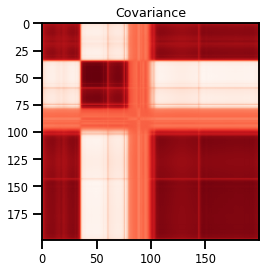

In [31]:
X_samples_cov = np.cov(X_samples_b, rowvar=False)

fig, ax = plt.subplots()

ax.imshow(np.cov(X_samples_cov,rowvar=False), cmap='Reds')
ax.set_title("Covariance")
plt.show()

<Figure size 360x360 with 0 Axes>

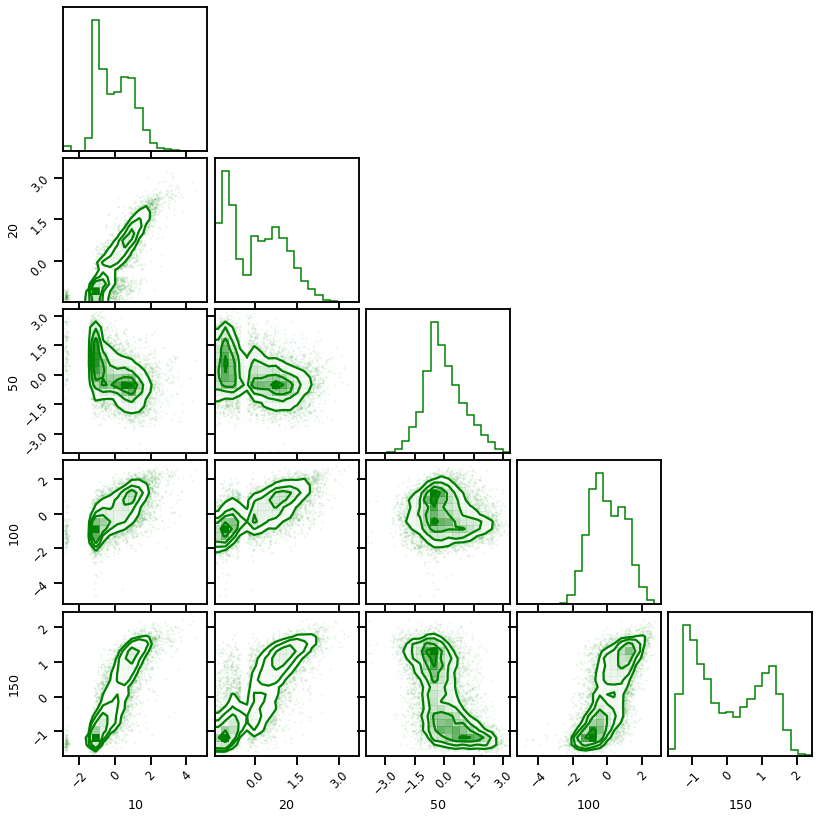

In [32]:
plt.figure(figsize=(5,5))

figure = corner.corner(
    xs=X_samples_b[:, bands],
    labels=bands,
    color="green", 
)